# Polar Data

__Description & purpose__: This Notebook is designed to demonstrate how to find and plot EOCIS related data held on the Earth Observation Data Hub.   It is assumed that this notebook will be running within the Notebook Service on the Hub.

The first thing to do is ensure that the most recent version of `pyeodh` is installed on your system. It is good practice to run the following cell if you have not installed `pyeodh` or have not used it in a while. The cell will also install the plotting and spatial libraries required.

In [ ]:
# Run this cell if pyeodh is not installed, or needs updating
!pip install --upgrade pyeodh
!pip install folium shapely xarray fsspec rioxarray cartopy pyproj

# Imports

In [ ]:
import pyeodh

import cartopy.crs as ccrs
import folium
import fsspec
import geopandas as gpd
import matplotlib.pyplot as plt
import pandas as pd

import shapely as sh
import xarray as xr
from pyproj import Transformer
from shapely.geometry import Point

# Set geographic locations

In [3]:
# Point of interest - ice/land (Nuuk, Greenland)
ipnt = sh.Point(-51.7216, 64.1835)

# Point of interest - ocean (Baffin Bay, Greenland)
olon, olat = [-54.22884, 83.11055]
opnt = sh.Point(olon, olat)

In [ ]:
# Create a folium map centred between the points
m = folium.Map(location=[(ipnt.y + opnt.y)/2, (ipnt.x + opnt.x)/2], zoom_start=3)

# Add points to the map
for pt, name in [(ipnt, "Nuuk"), (opnt, "Arctic Ocean")]:
    folium.Marker([pt.y, pt.x], popup=name).add_to(m)

m

# Exploring the Resource Catalogue

Now we are ready to investigate the Resource Catalogue. 

We need to create an instance of the `Client`, which is our entrypoint to EODH APIs. From there we can start to search the collections held within the platform. First we'll look at the paths to the data.

In [5]:
# Connect to the Hub
client = pyeodh.Client(base_url="https://eodatahub.org.uk").get_catalog_service()

for c in client.get_catalogs():
    print(c._pystac_object.self_href.removeprefix("https://eodatahub.org.uk/api/catalogue/stac/catalogs/"))


commercial/catalogs/airbus
user/catalogs/npl/catalogs/processing-results/catalogs/qa-workflow/catalogs/airbus_phr_qa
user/catalogs/tjellicoetpzuk/catalogs/processing-results/catalogs/snuggs/catalogs/catalog
public/catalogs/ceda-stac-catalogue
commercial
user/catalogs/npl
commercial/catalogs/planet
user/catalogs/npl/catalogs/processing-results/catalogs/qa-workflow/catalogs/planet_psscene_qa
user/catalogs/npl/catalogs/processing-results
user/catalogs/tjellicoetpzuk/catalogs/processing-results


Now we'll look explicitly for the EOCIS climate data.

In [6]:
for index, collect in enumerate(
        [c for c in client.get_collections() if "eocis" in c.id],
        start=1):
    print(f"{index} -- {collect.id}")


1 -- eocis-sst-cdrv3
2 -- eocis-soil-moisture-africa
3 -- eocis-lst-s3b-night
4 -- eocis-lst-s3b-day
5 -- eocis-lst-s3a-night
6 -- eocis-lst-s3a-day
7 -- eocis-chuk-land-vegetation-lai
8 -- eocis-chuk-land-vegetation-fapar
9 -- eocis-chuk-geospatial-landcover
10 -- eocis-chuk-geospatial-elevation
11 -- eocis-chuk-geospatial-builtarea
12 -- eocis-chuk-geospatial
13 -- eocis-arctic-sea-ice-thickness-monthly


# Sea Ice

Note: For additional details see this [link](https://www.cpom.ucl.ac.uk/eocis/seaice/product_info.php).

We need to connect to the Sea Ice collection and get some simple information about it

In [7]:
datasets = client.get_catalog(
    "public/catalogs/ceda-stac-catalogue").get_collection(
    'eocis-arctic-sea-ice-thickness-monthly')

print("id: ", datasets.id)
print("title: ", datasets.title)
print("description: ", datasets.description)
print("")
print(
    "DATASET TEMPORAL EXTENT: ",
    [str(d) for d in datasets.extent.temporal.intervals[0]],
)

id:  eocis-arctic-sea-ice-thickness-monthly
title:  EOCIS Arctic Monthly Gridded Sea Ice Thickness Product from CryoSat-2
description:  The sea ice products provide a 5x5 km grid of Arctic sea ice thickness (for the whole Arctic region and of 17 sub-regions), delivered as NetCDF files.  EOCIS sea ice thickness NetCDF products are generated monthly by the Centre for Polar Observation and Modelling (CPOM) from radar altimetry measurements taken from the ESA CryoSAT-2 satellite during the winter months (Oct-Apr). Sea ice thickness is only reliably measured from satellite radar altimetry during the winter months. During summer, melt ponds can form on the sea ice floes making it difficult for the satellite to differentiate between floes and leads, and hence calculate sea ice freeboard (and subsequently thickness). Measurement during summer months using radar altimetry is an area of active research (Landy et al, 2022) but is not yet operationally processed.

DATASET TEMPORAL EXTENT:  ['2010-

It would be useful to understand more about the items that are held within the catalogue. The attributes of a catalogue are mapped to a series of properties. For instance, we can find out the properties such as`id`, `title` and `description`.

In [8]:
# Now we want to access the first item and see what properties are available. Need to convert an iterator to a list first. 
items = list(datasets.get_items())
print("Number of items available: ", len(items))
print ("-----")

item = items[1]   # second item
print(f"\n{item.id}")
for k, v in item.properties.items():
    print(f"  {k}: {v}")


Number of items available:  198
-----

0a2cdd11-d4e1-4806-ab4f-1a66849cf30a
  title: EOCIS Arctic Monthly Gridded Sea Ice Thickness 2024-11-15
  description: The sea ice products provide a 5x5 km grid of Arctic sea ice thickness (for the whole Arctic region and of 17 sub-regions), delivered as NetCDF files.  EOCIS sea ice thickness NetCDF products are generated monthly by the Centre for Polar Observation and Modelling (CPOM) from radar altimetry measurements taken from the ESA CryoSAT-2 satellite during the winter months (Oct-Apr). Sea ice thickness is only reliably measured from satellite radar altimetry during the winter months. During summer, melt ponds can form on the sea ice floes making it difficult for the satellite to differentiate between floes and leads, and hence calculate sea ice freeboard (and subsequently thickness). Measurement during summer months using radar altimetry is an area of active research (Landy et al, 2022) but is not yet operationally processed.
  datetime: 

We can then get the item id, date and name for all items. It is recommended to only look at the first few as the number of items could be large.

In [9]:
# Warning: without the limit to 10 items this will take a long time for large catalogues
for item in datasets.get_items()[:10]:
    print(item.id, "---", item.properties["datetime"], "---", item.properties["title"])

ea60feff-3a21-49d1-b79f-9179c052cfc0 --- 2024-11-15T00:00:00Z --- EOCIS Sea-Surface Temperatures V3 2024-11-15
0a2cdd11-d4e1-4806-ab4f-1a66849cf30a --- 2024-11-15T00:00:00Z --- EOCIS Arctic Monthly Gridded Sea Ice Thickness 2024-11-15
f2a5764b-5f1e-4011-a8c2-d1eb75995d3b --- 2024-10-15T00:00:00Z --- EOCIS Sea-Surface Temperatures V3 2024-10-15
c2a3829e-ea0c-4379-be8c-da4f7e0e6c07 --- 2024-10-15T00:00:00Z --- EOCIS Arctic Monthly Gridded Sea Ice Thickness 2024-10-15
f476f3a5-14ca-4055-9b4d-d735946338ff --- 2024-04-15T00:00:00Z --- EOCIS Arctic Monthly Gridded Sea Ice Thickness 2024-04-15
d3ee4814-f522-4bf9-99d6-45bff8018cec --- 2024-04-15T00:00:00Z --- EOCIS Sea-Surface Temperatures V3 2024-04-15
aa5d9ec6-d7f3-4a23-b55b-ee6751bb7170 --- 2024-03-15T00:00:00Z --- EOCIS Arctic Monthly Gridded Sea Ice Thickness 2024-03-15
113583bf-a0d3-499d-9252-ea6ec096abe7 --- 2024-03-15T00:00:00Z --- EOCIS Sea-Surface Temperatures V3 2024-03-15
d9caf30d-ca73-4673-a079-17342019c598 --- 2024-02-14T00:00:00

The next thing to do is find out what assets are held within each item. The asset is the actual data that we are interested in. We will look at the asset information for the first item returned in the list.

In [10]:
for item in items[:1]:  # Process only the second item
    print(f"Item ID: {item.id}")
    print(f"Item name: {item.properties["title"]}")
    print("Assets:")
    
    if not item.assets:
        print("  No assets available.")
    else:
        for asset_key, asset in item.assets.items():
            print(f"  - {asset_key}: {asset.to_dict()}")  # Convert asset to dict for readable output
            print("-" * 40)  # Separator for better readability

Item ID: ea60feff-3a21-49d1-b79f-9179c052cfc0
Item name: EOCIS Sea-Surface Temperatures V3 2024-11-15
Assets:
  - reference_file: {'href': 'https://gws-access.jasmin.ac.uk/public/nceo_uor/eocis-stac/eocis-arctic-sea-ice-thickness-monthly-aux/items/2024/11/EOCIS-SEAICE-L3C-SITHICK-CS2-5KM-202411-fv1.0-kerchunk.json', 'type': 'application/zstd', 'cloud_format': 'kerchunk', 'checksum_type': None, 'open_kwargs': {'open_mapper_kwargs': {}, 'open_zarr_kwargs': {}, 'open_xarray_kwargs': {}}, 'size': None, 'checksum': None, 'roles': ['reference', 'data']}
----------------------------------------
  - EOCIS-SEAICE-L3C-SITHICK-CS2-5KM-202411-fv1.0: {'href': 'https://dap.ceda.ac.uk/neodc/eocis/data/global_and_regional/arctic_sea_ice/arctic_sea_ice_thickness_grids/L3C/monthly/v1.0/EOCIS-SEAICE-L3C-SITHICK-CS2-5KM-202411-fv1.0.nc', 'type': 'application/netcdf', 'roles': ['data']}
----------------------------------------


Now we are ready to load some data and visualise it. To do this we will need to use `xarray`.

-- **Notes** --

The data are provided in `NetCDF` (Network Common Data Form) file format, a widely used standard for storing, sharing, and analyzing scientific data. NetCDF is designed to handle large, multi-dimensional datasets, such as temperature, precipitation, and wind speed, across space and time. The CEDA STAC library also contains reference files in `Kerchunk` format. Kerchunk is a lightweight reference file format that maps chunks of data in archival formats such as NetCDF that can be lazily loaded to access only the required data chunks for any given request. Rather than converting the source NetCDF to a different format, Kerchunk contains pointers to individual chunks of data and uses the `fsspec` library to assemble those chunks into the required array in a tool like `xarray`. 

In [18]:
item = items[1]

# --- Identify the kerchunk reference asset if it exists ---
asset = None

if "reference_file" in item.assets:
    asset = item.assets["reference_file"]
    href = asset.href
    is_kerchunk = True
else:
    # Fallback: use the first 'data' asset
    for k, a in item.assets.items():
        if "data" in a.roles or a.type == "application/netcdf":
            asset = a
            href = asset.href
            is_kerchunk = False
            break

print("Selected asset:", asset)

# Load the dataset depending on asset type
if is_kerchunk: # kerchunk: open via fsspec + zarr
    fs = fsspec.filesystem("reference", fo=href)
    mapper = fs.get_mapper("")
    ds = xr.open_dataset(mapper, engine="zarr", consolidated=False)
else:
    # netcdf: direct open file
    ds = xr.open_dataset(href)

print("\n=== DATASET SUMMARY ===")
print(ds)

print("\n=== VARIABLES ===")
print(list(ds.data_vars))

print("\n=== COORDINATES ===")
print(list(ds.coords))

print("\n=== GLOBAL ATTRIBUTES ===")
for k, v in ds.attrs.items():
    print(f"{k}: {v}")


Selected asset: <Asset href=https://gws-access.jasmin.ac.uk/public/nceo_uor/eocis-stac/eocis-arctic-sea-ice-thickness-monthly-aux/items/2024/11/EOCIS-SEAICE-L3C-SITHICK-CS2-5KM-202411-fv1.0-kerchunk.json>

=== DATASET SUMMARY ===
<xarray.Dataset> Size: 68MB
Dimensions:                   (yc: 2240, xc: 1520, time: 1, nv: 2)
Coordinates:
    lat                       (yc, xc) float32 14MB ...
    lon                       (yc, xc) float32 14MB ...
  * time                      (time) datetime64[ns] 8B 2024-11-15
  * xc                        (xc) float32 6kB -3.85e+06 -3.845e+06 ... 3.75e+06
  * yc                        (yc) float32 9kB -5.35e+06 -5.345e+06 ... 5.85e+06
Dimensions without coordinates: nv
Data variables:
    n_thickness_measurements  (time, yc, xc) int32 14MB ...
    polar_stereographic       float32 4B ...
    sea_ice_thickness         (time, yc, xc) float32 14MB ...
    sea_ice_thickness_stdev   (time, yc, xc) float32 14MB ...
    time_bnds                 (time, nv) d


Now we need to reproject and plot


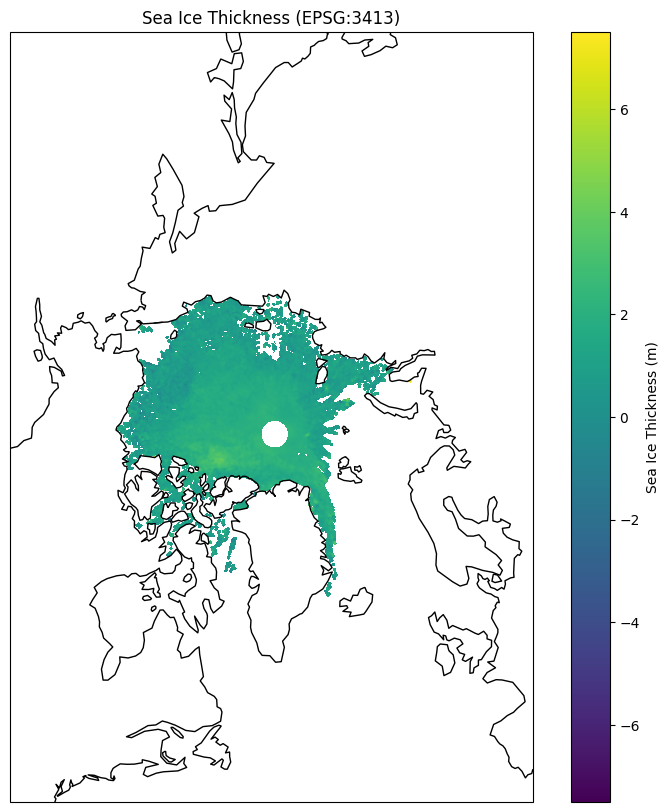

In [12]:

# set the projection
ds3413 = ds.rio.write_crs("EPSG:3413", inplace=False)
sit = ds3413["sea_ice_thickness"].squeeze()

proj = ccrs.Stereographic(central_latitude=90, central_longitude=-45)  # NSIDC default

plt.figure(figsize=(10,10))
ax = plt.axes(projection=proj)

# Transform from EPSG:3413 to map projection
sit.plot(
    ax=ax,
    transform=ccrs.epsg(3413),
    cmap="viridis",
    cbar_kwargs={"label": "Sea Ice Thickness (m)"}
)

ax.coastlines()
ax.set_title("Sea Ice Thickness (EPSG:3413)")
plt.show()


In [13]:
# Transform lon/lat for ocean point to EPSG:3413
to_3413 = Transformer.from_crs("EPSG:4326", "EPSG:3413", always_xy=True)
x0, y0 = to_3413.transform(olon, olat)

# 50 km buffer in metres
aoi_buffer = Point(x0, y0).buffer(50_000)   # 50 km radius

In [14]:
# Build GeoDataFrame in EPSG:3413
gdf = gpd.GeoDataFrame(
    {"geometry": [aoi_buffer]},
    crs="EPSG:3413"
)

# Clip to buffer polygon
sit_clip = sit.rio.clip(gdf.geometry, gdf.crs)

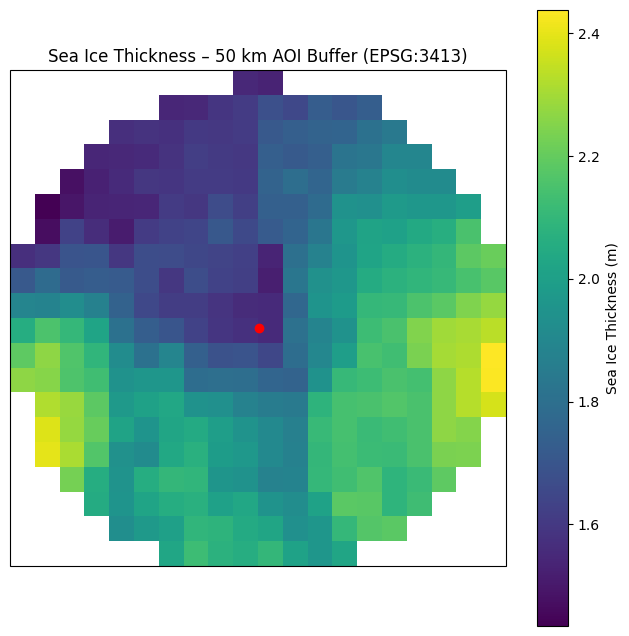

In [15]:
plt.figure(figsize=(8,8))
ax = plt.axes(projection=proj)

sit_clip.plot(
    ax=ax,
    transform=ccrs.epsg(3413),
    cmap="viridis",
    cbar_kwargs={"label": "Sea Ice Thickness (m)"}
)

# Draw AOI point
ax.plot(x0, y0, "ro", markersize=6, transform=ccrs.epsg(3413))

ax.coastlines()
ax.set_title("Sea Ice Thickness – 50 km AOI Buffer (EPSG:3413)")
plt.show()


# Sea Surface Temperature

We can do something similar for other datasets. We would usually follow the data discovery steps above for each dataset we are interested in. For brevity we can access the `href` that we require by completing an online search and copying the reference file `href` into the cell below. 

In [16]:

nhref = "https://gws-access.jasmin.ac.uk/public/nceo_uor/eocis-stac/sst-cdrv3-aux/items/2024/06/20240621120000-ESACCI-L4_GHRSST-SSTdepth-OSTIA-GLOB_ICDR3.0-v02.0-fv01.0-kerchunk.json"

# Load the dataset 
fsst = fsspec.filesystem("reference", fo=nhref)
mapper1 = fsst.get_mapper("")
dsst = xr.open_dataset(mapper1, engine="zarr", consolidated=False)

print("\n=== DATASET SUMMARY ===")
print(dsst)

print("\n=== VARIABLES ===")
print(list(dsst.data_vars))

print("\n=== COORDINATES ===")
print(list(dsst.coords))

print("\n=== GLOBAL ATTRIBUTES ===")
for k, v in dsst.attrs.items():
    print(f"{k}: {v}")


=== DATASET SUMMARY ===
<xarray.Dataset> Size: 726MB
Dimensions:                   (time: 1, lat: 3600, lon: 7200, bnds: 2)
Coordinates:
  * lat                       (lat) float32 14kB -89.97 -89.93 ... 89.93 89.97
  * lon                       (lon) float32 29kB -180.0 -179.9 ... 179.9 180.0
  * time                      (time) datetime64[ns] 8B 2024-06-21T12:00:00
Dimensions without coordinates: bnds
Data variables:
    analysed_sst              (time, lat, lon) float64 207MB ...
    analysed_sst_uncertainty  (time, lat, lon) float64 207MB ...
    lat_bnds                  (lat, bnds) float32 29kB ...
    lon_bnds                  (lon, bnds) float32 58kB ...
    mask                      (time, lat, lon) float32 104MB ...
    sea_ice_fraction          (time, lat, lon) float64 207MB ...
    time_bnds                 (time, bnds) datetime64[ns] 16B ...
Attributes: (12/66)
    Conventions:                    CF-1.5, Unidata Observation Dataset v1.0
    Metadata_Conventions:          

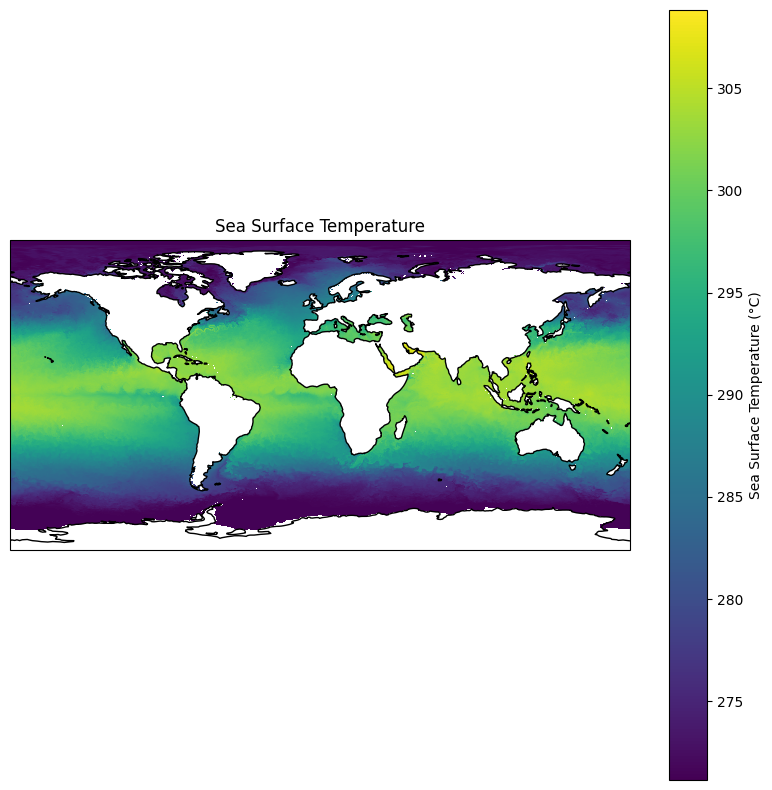

In [17]:

# Extract SST variable
sst = dsst["analysed_sst"].squeeze()   # already in EPSG:4326

proj = ccrs.PlateCarree()  # map projection = EPSG:4326

plt.figure(figsize=(10,10))
ax = plt.axes(projection=proj)

sst.plot(
    ax=ax,
    transform=ccrs.PlateCarree(),   # IMPORTANT: matches data CRS
    cmap="viridis",
    cbar_kwargs={"label": "Sea Surface Temperature (°C)"}
)

ax.coastlines()
ax.set_title("Sea Surface Temperature")
plt.show()

